Question 1 Part (a)

[ 0.03519016  0.04106206  0.05885948  0.05683611  0.0585952   0.05443284
  0.0550605   0.05067515  0.04785894  0.04083908  0.04269728  0.03509931
  0.03660239  0.03168022  0.02978073  0.0285089   0.0250733   0.02119173
  0.02142297  0.01859025  0.02086964  0.01462609  0.01422967  0.01295784
  0.01271834  0.0103894   0.01000124  0.00758145  0.00851468  0.00737498
  0.0096296   0.00611141  0.00575629  0.00503778  0.00509559  0.00437709
  0.00379898  0.00299789  0.00313829  0.0025767   0.01897015  0.02319032]
[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 250000, 350000]
44
[ 0.03519016  0.04106206  0.05885948  0.05683611  0.0585952   0.05443284
  0.0550605   0.05067515  0.04785894  0.04083908  0.04269728  0.03509931
  0.03660239  0.031

<IPython.core.display.Javascript object>


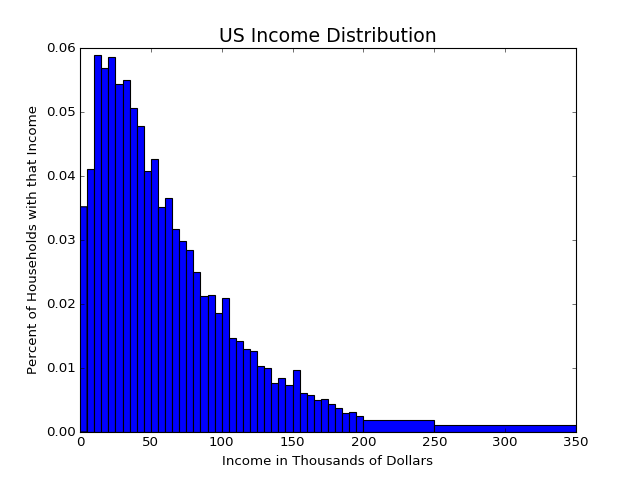

In [2]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

income  = np.loadtxt('usincmoms.txt')
#print(income)
#print(len(income))

print(income[:,0])

# change the value of income to be in thousands of dollars and then divide the frequencies for the two large bins at end
income_per_thou = income[:,1]/1000
income_perc = np.copy(income[:,0])
weights = income[:,0]
weights[40] = income[40,0]/10
weights[41] = income[41,0]/20
bins = list(range(0,205,5)) + [250,350]
bins2 = [x*1000 for x in bins]
print(bins2)
print(len(bins + [np.infty]))
print(income_perc)
print(weights)

# plot the histogram of income as described in question
plt.hist(income_per_thou, bins = bins, weights = weights)
plt.title('US Income Distribution', fontsize=17)
plt.xlabel(r'Income in Thousands of Dollars')
plt.ylabel(r'Percent of Households with that Income')

Question 1 Part (b)

In [3]:
def lognorm_pdf(xvals, mu, sigma):

    pdf_vals    = (1/(sigma * np.sqrt(2 * np.pi) * xvals) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    
    return pdf_vals

def norm_pdf(xvals, mu, sigma):
    
    pdf_vals    = (1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (xvals - mu)**2 / (2 * sigma**2)))
    
    return pdf_vals


In [4]:
def model_moments(mu, sigma, bins):

    model_mom_list = [] #np.empty([1,42])
    bins[0] = 1e-8
    bins = bins + [np.infty]
    xfx = lambda x: lognorm_pdf(x, mu, sigma)
    
    for i in range(1,len(bins)-1):
        #model_mom_list[i-1] = intgr.quad(xfx, bins[i-1], bins[i])[0]
        model_mom_list.append(intgr.quad(xfx, bins[i-1], bins[i])[0])
    
    return model_mom_list


def err_vec(mu, sigma, bins, weights, simple):

    #mean_data, var_data = data_moments(xvals)
    moms_data = np.array([weights])
    moms_model = model_moments(mu, sigma, bins)
    #moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):

    mu, sigma = params
    W, weights, bins = args
    err = err_vec(mu, sigma, bins, weights, simple=False)
    crit_val = np.dot(np.dot(err, W), err.T) 
    
    return crit_val

In [5]:
#len(model_moments(500,100,bins))
#W_hat = np.diag(weights,0)
#gmm_args = (income_per_thou,W_hat)
#criterion(np.array([500,100]), 
#err_vec(10, 10, bins, weights, simple=False)
#mu_check, sig_check = 16.4984125712, 8.6947160309
#print(np.array(err_vec(mu_check, sig_check, bins, weights, simple=False)))
#criterion(np.array([mu_check, sig_check]), (W_hat, weights, bins))
#print(weights)
#print(income[:,0])

In [6]:
mu_init = np.log(np.average(income[:,1], weights = income[:,0]))
sig_init = 10
print('Initial mu_0=', mu_init, 'Initial sigma_0=', sig_init)
params_init = np.array([mu_init, sig_init])
W_hat = np.diag(income_perc,0)
gmm_args = (W_hat, income_perc, bins)
#results = opt.minimize(criterion, params_init, args=(gmm_args), method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
minimizer_kwargs = dict(method="L-BFGS-B", 
                       bounds= ((None, None), (1e-10, None)),
                       args = gmm_args)
results = opt.basinhopping(criterion, params_init, minimizer_kwargs= minimizer_kwargs)
print(results)
mu_GMM1, sig_GMM1 = results.x
max_crit = results.fun
#max_crit = criterion(np.array([mu_GMM1,sig_GMM1]),([income_per_thou, W_hat]))
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1, 'Minimized Criterion=', max_crit)
print(np.array(model_moments(mu_GMM1,sig_GMM1,bins)))
print(np.array(model_moments(mu_GMM1,sig_GMM1,bins)).sum())

Initial mu_0= 10.9866918991 Initial sigma_0= 10
                        fun: array([[ 0.03551648]])
 lowest_optimization_result:       fun: array([[ 0.03551648]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.85722573e-09,   1.04083409e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 6
   status: 0
  success: True
        x: array([ 3.89344561,  0.97573644])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 2589
                        nit: 100
                          x: array([ 3.89344561,  0.97573644])
mu_GMM1= 3.89344560851  sig_GMM1= 0.975736436225 Minimized Criterion= [[ 0.03551648]]
[ 0.00962113  0.04188521  0.06070101  0.06656944  0.06589782  0.06228431
  0.0575227   0.05248761  0.04759512  0.04303081  0.03886373  0.03510454
  0.03173559  0.02872667  0.02604326  0.02365068  0.0215162   0.01960

<IPython.core.display.Javascript object>


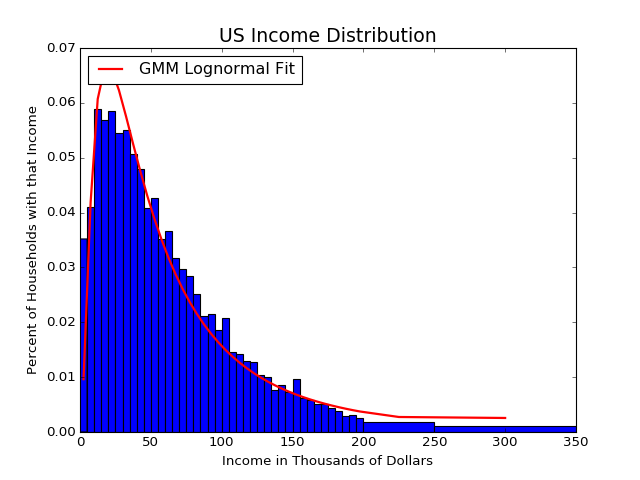

In [7]:
%matplotlib notebook
plt.hist(income_per_thou, bins = bins, weights = weights)
# Plot the MLE estimated distribution
moments_plot = model_moments(mu_GMM1, sig_GMM1, bins)
moments_plot[40] = moments_plot[40]/10
moments_plot[41] = moments_plot[41]/10

plt.plot(income_per_thou, moments_plot,
         linewidth=2, color='r', label='GMM Lognormal Fit')
plt.legend(loc='upper left')
plt.title('US Income Distribution', fontsize=17)
plt.xlabel(r'Income in Thousands of Dollars')
plt.ylabel(r'Percent of Households with that Income')

Question 1 Part (c)

In [8]:
import scipy.special as spe

def gamma_pdf(xvals, alpha, beta):
        
    #pdf_vals = ((pow(xvals,alpha-1))*np.exp(-xvals/beta))/(spe.gamma(alpha)*(pow(beta,alpha)))
    pdf_vals = xvals**(alpha-1)*(np.exp(-xvals/beta)/(spe.gamma(alpha)*beta**alpha))
    #pdf_vals = sts.gamma.pdf(xvals, alpha, loc = 0, scale = beta)
    
    return pdf_vals

In [9]:
def model_moments_gamma(alpha, beta, bins):

    model_mom_list = [] #np.empty([1,42])
    bins[0] = 1e-8
    bins = bins + [np.infty]
    xfx = lambda x: gamma_pdf(x, alpha, beta)
    
    for i in range(1,len(bins)-1):
        #model_mom_list[i-1] = intgr.quad(xfx, bins[i-1], bins[i])[0]
        model_mom_list.append(intgr.quad(xfx, bins[i-1], bins[i])[0])
    
    return model_mom_list


def err_vec_gamma(alpha, beta, bins, weights, simple):

    #mean_data, var_data = data_moments(xvals)
    moms_data = np.array([weights])
    moms_model = model_moments_gamma(alpha, beta, bins)
    #moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion_gamma(params, *args):

    alpha, beta = params
    W, weights, bins = args
    err = err_vec_gamma(alpha, beta, bins, weights, simple=False)
    crit_val = np.dot(np.dot(err, W), err.T) 
    
    return crit_val

In [10]:
alpha_init = 3
beta_init = 20000
print('Initial alpha_0=', alpha_init, 'Initial beta_0=', beta_init)
params_init1 = np.array([alpha_init, beta_init])
W_hat1 = np.diag(income_perc,0)
gmm_args1 = (W_hat1, income_perc, bins2)
#results_gamma = opt.minimize(criterion_gamma, params_init1, args=(gmm_args1), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
minimizer_kwargs1 = dict(method="L-BFGS-B", 
                       bounds= ((1e-10, None), (1e-10, None)),
                       args = gmm_args1)
results_gamma = opt.basinhopping(criterion_gamma, params_init1, minimizer_kwargs= minimizer_kwargs1)
print(results_gamma)
alpha_GMM1, beta_GMM1 = results_gamma.x
max_crit_gamma = results_gamma.fun
#max_crit = criterion(np.array([mu_GMM1,sig_GMM1]),([income_per_thou, W_hat]))
print('alpha_GMM1=', alpha_GMM1, ' beta_GMM1=', beta_GMM1, 'Minimized Criterion=', max_crit_gamma)
print(np.array(model_moments_gamma(alpha_GMM1,beta_GMM1,bins)))
print(np.array(model_moments_gamma(alpha_GMM1,beta_GMM1,bins)).sum())

Initial alpha_0= 3 Initial beta_0= 20000
                        fun: array([[ 0.01408492]])
 lowest_optimization_result:       fun: array([[ 0.01408492]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.79384024e-07,   6.93889390e-10])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 5
   status: 0
  success: True
        x: array([  1.36707212e+00,   4.80620371e+04])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 2073
                        nit: 100
                          x: array([  1.36707212e+00,   4.80620371e+04])
alpha_GMM1= 1.36707211927  beta_GMM1= 48062.037116 Minimized Criterion= [[ 0.01408492]]
[  2.95250172e-06   4.66290512e-06   5.64009844e-06   6.38580149e-06
   7.00439854e-06   7.54023862e-06   8.01698148e-06   8.44896125e-06
   8.84561278e-06   9.21352215e-06   9.55749374e-06   9.881154

<IPython.core.display.Javascript object>


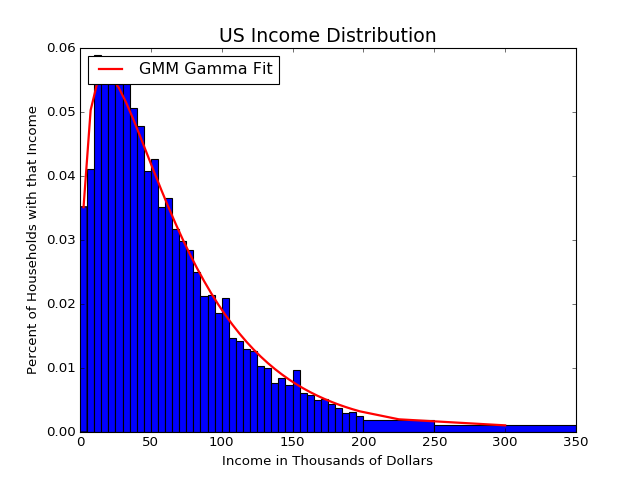

In [11]:
%matplotlib notebook
plt.hist(income_per_thou, bins = bins, weights = weights)
# Plot the MLE estimated distribution
moments_plot_gamma = model_moments_gamma(alpha_GMM1, beta_GMM1, bins2)
moments_plot_gamma[40] = moments_plot_gamma[40]/10
moments_plot_gamma[41] = moments_plot_gamma[41]/10

plt.plot(income_per_thou, moments_plot_gamma,
         linewidth=2, color='r', label='GMM Gamma Fit')
plt.legend(loc='upper left')
plt.title('US Income Distribution', fontsize=17)
plt.xlabel(r'Income in Thousands of Dollars')
plt.ylabel(r'Percent of Households with that Income')

Question 1 Part (d)

<IPython.core.display.Javascript object>


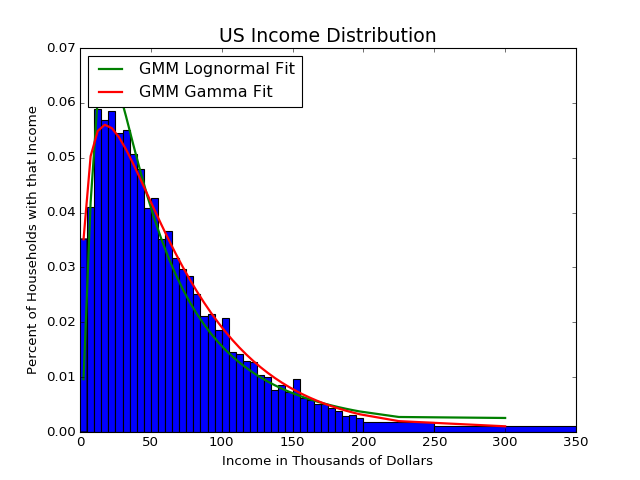

In [12]:
%matplotlib notebook
plt.hist(income_per_thou, bins = bins, weights = weights)
# Plot the MLE estimated distribution
moments_plot_gamma = model_moments_gamma(alpha_GMM1, beta_GMM1, bins2)
moments_plot_gamma[40] = moments_plot_gamma[40]/10
moments_plot_gamma[41] = moments_plot_gamma[41]/10

plt.plot(income_per_thou, moments_plot, linewidth=2, color='g', label='GMM Lognormal Fit')
plt.plot(income_per_thou, moments_plot_gamma, linewidth=2, color='r', label='GMM Gamma Fit')
plt.legend(loc='upper left')
plt.title('US Income Distribution', fontsize=17)
plt.xlabel(r'Income in Thousands of Dollars')
plt.ylabel(r'Percent of Households with that Income')

Question 1 Part (e)

In [25]:

#err1 = err_vec_gamma(alpha_GMM1, beta_GMM1, bins, income[:,0], False)
err1 = err_vec_gamma(alpha_GMM1, beta_GMM1, bins2, income_perc, False)
print(err1)
#N = 121084000
N = 1
VCV2 = np.outer(err1.T, err1.T) / N
print(VCV2)
#print(len(VCV2))
W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2)
print(weights.shape[0])
'''
N = 121084000
draws = np.random.gamma(alpha_GMM1, beta_GMM1, size = (N,1))
'''

[[-0.0020988   0.22458159 -0.06784547 -0.01455273 -0.05484279 -0.01272073
  -0.06461589 -0.03457066 -0.0353644   0.06127976 -0.05092093  0.07583011
  -0.04135184  0.0267879   0.01054334 -0.02507842  0.02219178  0.11373941
   0.01333765  0.07291523 -0.12273237  0.14798168  0.08128151  0.08731669
   0.0137341   0.13491621  0.07759209  0.29862154  0.05580136  0.11252167
  -0.22268499  0.11693515  0.08101086  0.12560271  0.01377049  0.0747929
   0.12743621  0.30038686  0.13034643  0.25241675  0.04480392 -0.55203505]]
[[  4.40498098e-06  -4.71352890e-04   1.42394378e-04 ...,  -5.29773450e-04
   -9.40346684e-05   1.15861372e-03]
 [ -4.71352890e-04   5.04368912e-02  -1.52368425e-02 ...,   5.66881555e-02
    1.00621349e-02  -1.23976909e-01]
 [  1.42394378e-04  -1.52368425e-02   4.60300714e-03 ...,  -1.71253318e-02
   -3.03974255e-03   3.74530744e-02]
 ..., 
 [ -5.29773450e-04   5.66881555e-02  -1.71253318e-02 ...,   6.37142158e-02
    1.13092590e-02  -1.39342892e-01]
 [ -9.40346684e-05   1.006

In [32]:
'''
alpha_init = 3
beta_init = 20000
print('Initial alpha_0=', alpha_init, 'Initial beta_0=', beta_init)
params_init1 = np.array([alpha_init, beta_init])
#W_hat1 = np.diag(income_perc,0)
W_hat1 = np.eye(42)
gmm_args1 = (W_hat1, income_perc, bins2)
#results_gamma = opt.minimize(criterion_gamma, params_init1, args=(gmm_args1), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
minimizer_kwargs1 = dict(method="L-BFGS-B", 
                       bounds= ((1e-10, None), (1e-10, None)),
                       args = gmm_args1)
results_gamma = opt.basinhopping(criterion_gamma, params_init1, minimizer_kwargs= minimizer_kwargs1)
print(results_gamma)
alpha_GMM1_test, beta_GMM1_test = results_gamma.x

err1_test = err_vec_gamma(alpha_GMM1_test, beta_GMM1_test, bins2, income_perc, False)
print(err1_test)
#VCV2_test = np.dot(err1_test.T, err1_test) / weights.shape[0]
VCV2_test = np.outer(err1_test.T,err1_test.T) / weights.shape[0]
print(VCV2_test)
#print(len(VCV2))
W_hat2_test = lin.pinv(VCV2_test)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2_test)
print(weights.shape[0])
'''

#print('Initial alpha_0=', alpha_init, 'Initial beta_0=', beta_init)
params_init_gamma2 = np.array([alpha_GMM1, beta_GMM1])
#params_init_gamma2 = np.array([1.836, 27.84])
print('Initial alpha = ', alpha_GMM1, 'Initial beta = ', beta_GMM1)
#W_hat = np.diag(weights,0)
gmm_args_gamma2 = (W_hat2, income_perc, bins2)
#results_gamma2 = opt.minimize(criterion_gamma, params_init_gamma2, args=(gmm_args_gamma2), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
minimizer_kwargs2 = dict(method="L-BFGS-B", 
                       bounds= ((1e-10, None), (1e-10, None)),
                       args = gmm_args_gamma2,
                       options={'eps': 1e-8})
results_gamma2 = opt.basinhopping(criterion_gamma, params_init_gamma2, niter = 100, minimizer_kwargs= minimizer_kwargs2)
print(results_gamma2)
alpha_GMM2, beta_GMM2 = results_gamma2.x
max_crit_gamma2 = results_gamma2.fun
#max_crit = criterion(np.array([mu_GMM1,sig_GMM1]),([income_per_thou, W_hat]))
print('alpha_GMM2=', alpha_GMM2, ' beta_GMM2=', beta_GMM2, 'Minimized Criterion=', max_crit_gamma2)
print(np.array(model_moments_gamma(alpha_GMM2,beta_GMM2,bins)))
print(np.array(model_moments_gamma(alpha_GMM2,beta_GMM2,bins)).sum())

Initial alpha =  1.36707211927 Initial beta =  48062.037116
                        fun: array([[ -5.66222562e-17]])
 lowest_optimization_result:       fun: array([[ -5.66222562e-17]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.28574074e-08,   1.93070025e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 6
   status: 0
  success: True
        x: array([  9.64877581e-01,   4.80671986e+04])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 2205
                        nit: 100
                          x: array([  9.64877581e-01,   4.80671986e+04])
alpha_GMM2= 0.964877581272  beta_GMM2= 48067.1985797 Minimized Criterion= [[ -5.66222562e-17]]
[ 0.00014563  0.00013861  0.00013607  0.00013444  0.00013324  0.00013229
  0.0001315   0.00013083  0.00013024  0.00012972  0.00012925  0.00012882
  0.00012843  0.00

<IPython.core.display.Javascript object>


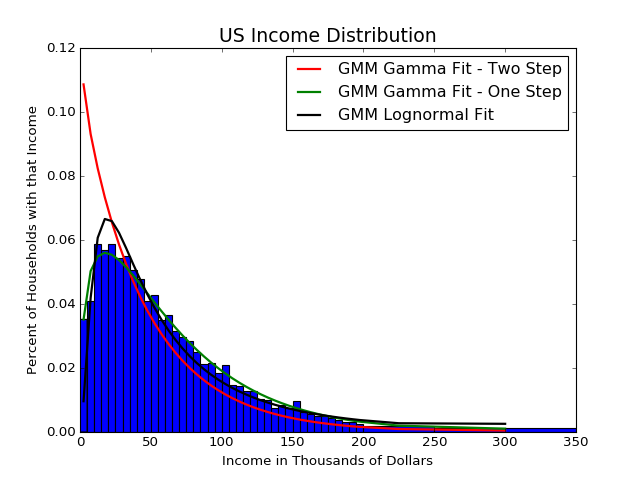

In [33]:
%matplotlib notebook
plt.hist(income_per_thou, bins = bins, weights = weights)
# Plot the MLE estimated distribution
moments_plot_gamma2 = model_moments_gamma(alpha_GMM2, beta_GMM2, bins2)
moments_plot_gamma2[40] = moments_plot_gamma2[40]/10
moments_plot_gamma2[41] = moments_plot_gamma2[41]/10

#plt.plot(income_per_thou, moments_plot, linewidth=2, color='g', label='GMM Lognormal Fit')
plt.plot(income_per_thou, moments_plot_gamma2, linewidth=2, color='r', label='GMM Gamma Fit - Two Step')
plt.plot(income_per_thou, moments_plot_gamma, linewidth=2, color='g', label='GMM Gamma Fit - One Step')
plt.plot(income_per_thou, moments_plot, linewidth=2, color='k', label='GMM Lognormal Fit')
plt.legend(loc='upper right')
plt.title('US Income Distribution', fontsize=17)
plt.xlabel(r'Income in Thousands of Dollars')
plt.ylabel(r'Percent of Households with that Income')